In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, lqr
import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def _actor_initial_weight(actor):
    # 安定化ゲインに書き換える
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.01]])
    
    K = lqr(A,B,Q,R)[0]
    
    weights = []
    for i in range(len(actor.layers)):
        if i < 2:
            continue
        else:
            w, b = actor.layers[i].get_weights()
            w, b = np.zeros_like(w), np.zeros_like(b)
            if i == 2:
                w[0][0] = K[0]
                w[1][0] = K[1]
            elif i == 4:
                w[0][0] = 1
                w[1][1] = 1
            else:
                w[0][0] = 1
            weights.append(w)
            weights.append(b)
    return weights

def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(16, activation="single_lin_relu_sig")(x)
    x = Dense(3, activation="single_lin_tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    actor.summary()
    actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [ ]:
#safe learning
l = 0.5
step = 300000
episode_step = int(200 * 0.05 / dt)
time_mode = False
a = agent((3,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, loss_graph=0, time_mode=time_mode, pure=1)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________



Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 66s 7ms/step - reward: -0.7967

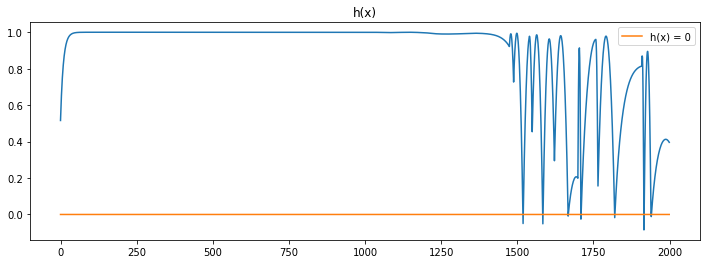

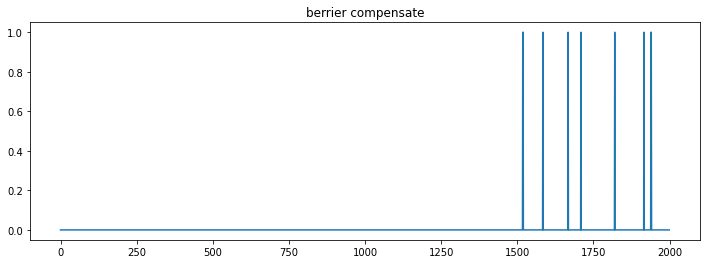

In [44]:
# first episode log
episode_step = int(200 * 0.05 / dt)
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[:episode_step,0])
plt.plot(range(episode_step), np.zeros(episode_step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[:episode_step,1])
plt.show()

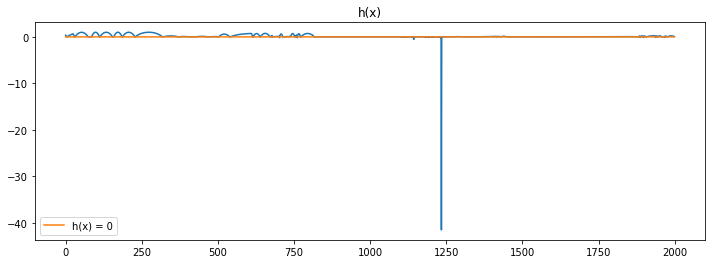

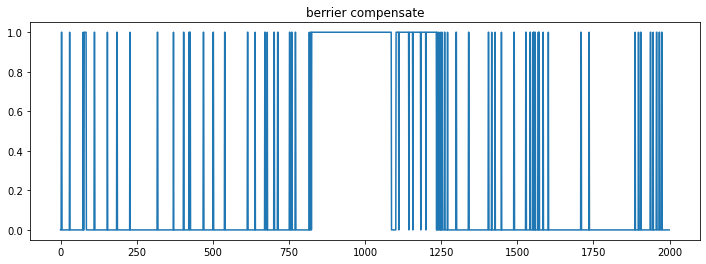

In [6]:
# log per episode
interval = 10
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1), 0])
plt.plot(range(episode_step), np.zeros(episode_step ,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1),1])
plt.show()

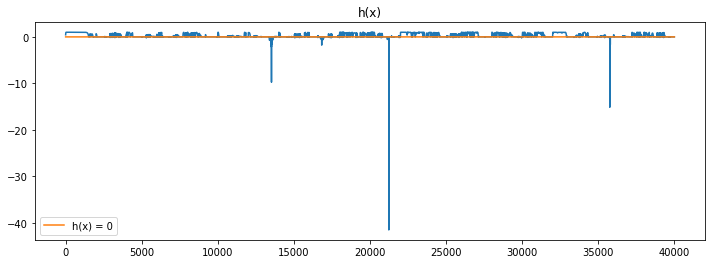

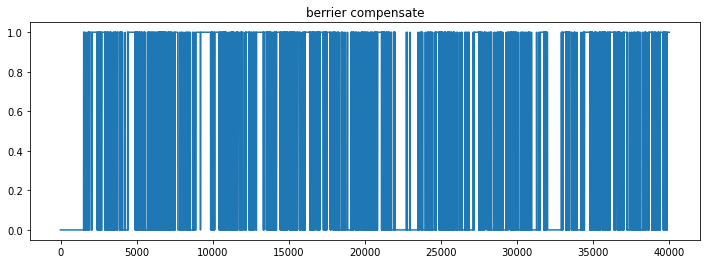

In [7]:
# log throughout learning
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(step), a.cbf_log[:,0])
plt.plot(range(step), np.zeros(step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(step), a.cbf_log[:,1])
plt.show()

In [8]:
# a.load_weights('../learned_models_safe/3000000_e2000_l05_pure.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=episode_step, action_view=1, time_mode=time_mode, pure=1)

Testing for 1 episodes ...
step =  1 , output of actor network =  [-2.2317555  -0.88770294  0.960069  ]
step =  2 , output of actor network =  [-2.1194654  -0.88017595  0.95862097]
step =  3 , output of actor network =  [-2.0031526  -0.87191826  0.9570941 ]
step =  4 , output of actor network =  [-1.8827938  -0.86286134  0.95548916]
step =  5 , output of actor network =  [-1.7583674 -0.8529328  0.953809 ]
step =  6 , output of actor network =  [-1.6298549 -0.8420567  0.9520582]
step =  7 , output of actor network =  [-1.497241   -0.8301548   0.95024407]
step =  8 , output of actor network =  [-1.3605151  -0.8171483   0.94837815]
step =  9 , output of actor network =  [-1.2196729  -0.80296105  0.9464762 ]
step =  10 , output of actor network =  [-1.074717   -0.78752226  0.9445598 ]
step =  11 , output of actor network =  [-0.9256586  -0.7707713   0.94265723]
step =  12 , output of actor network =  [-0.7725198  -0.7526645   0.94080573]
step =  13 , output of actor network =  [-0.61533713

step =  179 , output of actor network =  [-0.16765097 -0.67347753  0.93529147]
step =  180 , output of actor network =  [-0.18376034 -0.67571276  0.9353859 ]
step =  181 , output of actor network =  [-0.19866061 -0.6777756   0.93547636]
step =  182 , output of actor network =  [-0.21235701 -0.679668    0.9355622 ]
step =  183 , output of actor network =  [-0.2248528  -0.68139106  0.93564266]
step =  184 , output of actor network =  [-0.23615196 -0.682946    0.9357173 ]
step =  185 , output of actor network =  [-0.24625698 -0.6843346   0.9357854 ]
step =  186 , output of actor network =  [-0.25517082 -0.6855575   0.93584657]
step =  187 , output of actor network =  [-0.26289597 -0.6866158   0.9359004 ]
step =  188 , output of actor network =  [-0.26943466 -0.68751055  0.93594646]
step =  189 , output of actor network =  [-0.27478924 -0.68824244  0.9359846 ]
step =  190 , output of actor network =  [-0.27896085 -0.68881226  0.93601465]
step =  191 , output of actor network =  [-0.2819502

step =  291 , output of actor network =  [ 2.7848918  -0.99763066  1.0000001 ]
step =  292 , output of actor network =  [ 2.7726116 -0.9981073  1.       ]
step =  293 , output of actor network =  [ 2.7605205  -0.99848914  1.        ]
step =  294 , output of actor network =  [ 2.7486224  -0.99879456  1.        ]
step =  295 , output of actor network =  [ 2.7369199  -0.99903905  1.        ]
step =  296 , output of actor network =  [ 2.7254188  -0.99923444  1.        ]
step =  297 , output of actor network =  [ 2.7141185  -0.99939054  1.        ]
step =  298 , output of actor network =  [ 2.7030241  -0.99951524  1.        ]
step =  299 , output of actor network =  [ 2.6921372 -0.9996148  1.       ]
step =  300 , output of actor network =  [ 2.6814594  -0.99969417  1.        ]
step =  301 , output of actor network =  [ 2.6709933  -0.99975747  1.        ]
step =  302 , output of actor network =  [ 2.6607401 -0.9998077  1.       ]
step =  303 , output of actor network =  [ 2.650701  -0.99984

step =  450 , output of actor network =  [ 2.291082 -1.        1.      ]
step =  451 , output of actor network =  [ 2.2901711 -1.         1.       ]
step =  452 , output of actor network =  [ 2.2892585 -1.         1.       ]
step =  453 , output of actor network =  [ 2.2883563 -1.         1.       ]
step =  454 , output of actor network =  [ 2.2874541 -1.         1.       ]
step =  455 , output of actor network =  [ 2.2865586 -1.         1.       ]
step =  456 , output of actor network =  [ 2.285666 -1.        1.      ]
step =  457 , output of actor network =  [ 2.284783 -1.        1.      ]
step =  458 , output of actor network =  [ 2.283896 -1.        1.      ]
step =  459 , output of actor network =  [ 2.2830195 -1.         1.       ]
step =  460 , output of actor network =  [ 2.282145 -1.        1.      ]
step =  461 , output of actor network =  [ 2.28128 -1.       1.     ]
step =  462 , output of actor network =  [ 2.2804132 -1.         1.       ]
step =  463 , output of actor net

step =  567 , output of actor network =  [ 2.2161155 -1.         1.       ]
step =  568 , output of actor network =  [ 2.2157636 -1.         1.       ]
step =  569 , output of actor network =  [ 2.2154212 -1.         1.       ]
step =  570 , output of actor network =  [ 2.2150798 -1.         1.       ]
step =  571 , output of actor network =  [ 2.214746 -1.        1.      ]
step =  572 , output of actor network =  [ 2.2144141 -1.         1.       ]
step =  573 , output of actor network =  [ 2.2140918 -1.         1.       ]
step =  574 , output of actor network =  [ 2.2137713 -1.         1.       ]
step =  575 , output of actor network =  [ 2.2134604 -1.         1.       ]
step =  576 , output of actor network =  [ 2.2131515 -1.         1.       ]
step =  577 , output of actor network =  [ 2.2128463 -1.         1.       ]
step =  578 , output of actor network =  [ 2.2125487 -1.         1.       ]
step =  579 , output of actor network =  [ 2.212255 -1.        1.      ]
step =  580 , outp

step =  681 , output of actor network =  [ 2.206533 -1.        1.      ]
step =  682 , output of actor network =  [ 2.2062888 -1.         1.       ]
step =  683 , output of actor network =  [ 2.2060332 -1.         1.       ]
step =  684 , output of actor network =  [ 2.2057738 -1.         1.       ]
step =  685 , output of actor network =  [ 2.2054973 -1.         1.       ]
step =  686 , output of actor network =  [ 2.205217 -1.        1.      ]
step =  687 , output of actor network =  [ 2.2049232 -1.         1.       ]
step =  688 , output of actor network =  [ 2.2046237 -1.         1.       ]
step =  689 , output of actor network =  [ 2.2050166 -1.         1.       ]
step =  690 , output of actor network =  [ 2.2054267 -1.         1.       ]
step =  691 , output of actor network =  [ 2.205854 -1.        1.      ]
step =  692 , output of actor network =  [ 2.2062964 -1.         1.       ]
step =  693 , output of actor network =  [ 2.206758 -1.        1.      ]
step =  694 , output of 

step =  836 , output of actor network =  [ 2.232902 -1.        1.      ]
step =  837 , output of actor network =  [ 2.2334523 -1.         1.       ]
step =  838 , output of actor network =  [ 2.2340074 -1.         1.       ]
step =  839 , output of actor network =  [ 2.2345662 -1.         1.       ]
step =  840 , output of actor network =  [ 2.2351327 -1.         1.       ]
step =  841 , output of actor network =  [ 2.2357001 -1.         1.       ]
step =  842 , output of actor network =  [ 2.2362761 -1.         1.       ]
step =  843 , output of actor network =  [ 2.236854 -1.        1.      ]
step =  844 , output of actor network =  [ 2.2374387 -1.         1.       ]
step =  845 , output of actor network =  [ 2.2380242 -1.         1.       ]
step =  846 , output of actor network =  [ 2.2386203 -1.         1.       ]
step =  847 , output of actor network =  [ 2.2392201 -1.         1.       ]
step =  848 , output of actor network =  [ 2.2398238 -1.         1.       ]
step =  849 , outp

step =  945 , output of actor network =  [ 2.2742448 -1.         1.       ]
step =  946 , output of actor network =  [ 2.2728257 -1.         1.       ]
step =  947 , output of actor network =  [ 2.2713637 -1.         1.       ]
step =  948 , output of actor network =  [ 2.269854 -1.        1.      ]
step =  949 , output of actor network =  [ 2.2682967 -1.         1.       ]
step =  950 , output of actor network =  [ 2.2666955 -1.         1.       ]
step =  951 , output of actor network =  [ 2.2650466 -1.         1.       ]
step =  952 , output of actor network =  [ 2.263351 -1.        1.      ]
step =  953 , output of actor network =  [ 2.2616067 -1.         1.       ]
step =  954 , output of actor network =  [ 2.2598176 -1.         1.       ]
step =  955 , output of actor network =  [ 2.2579741 -1.         1.       ]
step =  956 , output of actor network =  [ 2.2560868 -1.         1.       ]
step =  957 , output of actor network =  [ 2.2541509 -1.         1.       ]
step =  958 , outp

step =  1085 , output of actor network =  [ 2.2379785 -1.         1.       ]
step =  1086 , output of actor network =  [ 2.2381978 -1.         1.       ]
step =  1087 , output of actor network =  [ 2.2384267 -1.         1.       ]
step =  1088 , output of actor network =  [ 2.238667 -1.        1.      ]
step =  1089 , output of actor network =  [ 2.238912 -1.        1.      ]
step =  1090 , output of actor network =  [ 2.2391706 -1.         1.       ]
step =  1091 , output of actor network =  [ 2.2394366 -1.         1.       ]
step =  1092 , output of actor network =  [ 2.2397103 -1.         1.       ]
step =  1093 , output of actor network =  [ 2.2399926 -1.         1.       ]
step =  1094 , output of actor network =  [ 2.2402883 -1.         1.       ]
step =  1095 , output of actor network =  [ 2.2405887 -1.         1.       ]
step =  1096 , output of actor network =  [ 2.2408996 -1.         1.       ]
step =  1097 , output of actor network =  [ 2.2412229 -1.         1.       ]
step 

step =  1193 , output of actor network =  [ 2.307423 -1.        1.      ]
step =  1194 , output of actor network =  [ 2.3082156 -1.         1.       ]
step =  1195 , output of actor network =  [ 2.3090196 -1.         1.       ]
step =  1196 , output of actor network =  [ 2.3098292 -1.         1.       ]
step =  1197 , output of actor network =  [ 2.3106484 -1.         1.       ]
step =  1198 , output of actor network =  [ 2.3114743 -1.         1.       ]
step =  1199 , output of actor network =  [ 2.3123097 -1.         1.       ]
step =  1200 , output of actor network =  [ 2.3131557 -1.         1.       ]
step =  1201 , output of actor network =  [ 2.3140092 -1.         1.       ]
step =  1202 , output of actor network =  [ 2.3148751 -1.         1.       ]
step =  1203 , output of actor network =  [ 2.3157496 -1.         1.       ]
step =  1204 , output of actor network =  [ 2.3166347 -1.         1.       ]
step =  1205 , output of actor network =  [ 2.3175302 -1.         1.       ]
st

step =  1358 , output of actor network =  [ 2.348371 -1.        1.      ]
step =  1359 , output of actor network =  [ 2.3490634 -1.         1.       ]
step =  1360 , output of actor network =  [ 2.3497596 -1.         1.       ]
step =  1361 , output of actor network =  [ 2.3504643 -1.         1.       ]
step =  1362 , output of actor network =  [ 2.351172 -1.        1.      ]
step =  1363 , output of actor network =  [ 2.3518882 -1.         1.       ]
step =  1364 , output of actor network =  [ 2.352611 -1.        1.      ]
step =  1365 , output of actor network =  [ 2.3533406 -1.         1.       ]
step =  1366 , output of actor network =  [ 2.3540778 -1.         1.       ]
step =  1367 , output of actor network =  [ 2.3548207 -1.         1.       ]
step =  1368 , output of actor network =  [ 2.3555732 -1.         1.       ]
step =  1369 , output of actor network =  [ 2.3563352 -1.         1.       ]
step =  1370 , output of actor network =  [ 2.3571048 -1.         1.       ]
step =  

step =  1548 , output of actor network =  [-0.60857344 -0.7323243   0.93898106]
step =  1549 , output of actor network =  [-0.69041276 -0.74259686  0.93986857]
step =  1550 , output of actor network =  [-0.7734802  -0.75278085  0.94081694]
step =  1551 , output of actor network =  [-0.85780287 -0.7628582   0.94182193]
step =  1552 , output of actor network =  [-0.93909454 -0.7723171   0.94282514]
step =  1553 , output of actor network =  [-0.93515706 -0.77186483  0.9427759 ]
step =  1554 , output of actor network =  [-0.9289465  -0.7711503   0.94269824]
step =  1555 , output of actor network =  [-0.92046225 -0.77017164  0.94259256]
step =  1556 , output of actor network =  [-0.91048133 -0.7690168   0.94246846]
step =  1557 , output of actor network =  [-0.89825225 -0.7675968   0.9423173 ]
step =  1558 , output of actor network =  [-0.8837719  -0.7659075   0.94213885]
step =  1559 , output of actor network =  [-0.8670378  -0.7639455   0.94193435]
step =  1560 , output of actor network =

step =  1725 , output of actor network =  [-0.6385987 -0.7361199  0.9393009]
step =  1726 , output of actor network =  [-0.60194933 -0.73148274  0.93891144]
step =  1727 , output of actor network =  [-0.5638963 -0.7266202  0.9385184]
step =  1728 , output of actor network =  [-0.52443147 -0.7215272   0.93812376]
step =  1729 , output of actor network =  [-0.48354432 -0.7161987   0.93772954]
step =  1730 , output of actor network =  [-0.44122615 -0.7106298   0.9373383 ]
step =  1731 , output of actor network =  [-0.39746788 -0.70481646  0.9369528 ]
step =  1732 , output of actor network =  [-0.35225937 -0.69875425  0.936576  ]
step =  1733 , output of actor network =  [-0.30525348 -0.6923939   0.93620867]
step =  1734 , output of actor network =  [-0.2567679  -0.68577635  0.9358576 ]
step =  1735 , output of actor network =  [-0.20679367 -0.6788998   0.93552697]
step =  1736 , output of actor network =  [-0.15532209 -0.6717635   0.9352216 ]
step =  1737 , output of actor network =  [-0.

step =  1920 , output of actor network =  [-3.7894623 -0.9560604  0.9766578]
step =  1921 , output of actor network =  [-3.8083425  -0.95657057  0.97681665]
step =  1922 , output of actor network =  [-3.8269422  -0.9570677   0.97697216]
step =  1923 , output of actor network =  [-3.8452692  -0.95755184  0.9771245 ]
step =  1924 , output of actor network =  [-3.8633296  -0.95802414  0.9772737 ]
step =  1925 , output of actor network =  [-3.8811307 -0.9584846  0.97742  ]
step =  1926 , output of actor network =  [-3.8986788  -0.95893353  0.97756326]
step =  1927 , output of actor network =  [-3.7645836 -0.9553795  0.976447 ]
step =  1928 , output of actor network =  [-3.6244674  -0.95135003  0.97522813]
step =  1929 , output of actor network =  [-3.4782867  -0.9467757   0.97389793]
step =  1930 , output of actor network =  [-3.3259988  -0.94157547  0.97244716]
step =  1931 , output of actor network =  [-3.1675618  -0.9356559   0.97086674]
step =  1932 , output of actor network =  [-3.002

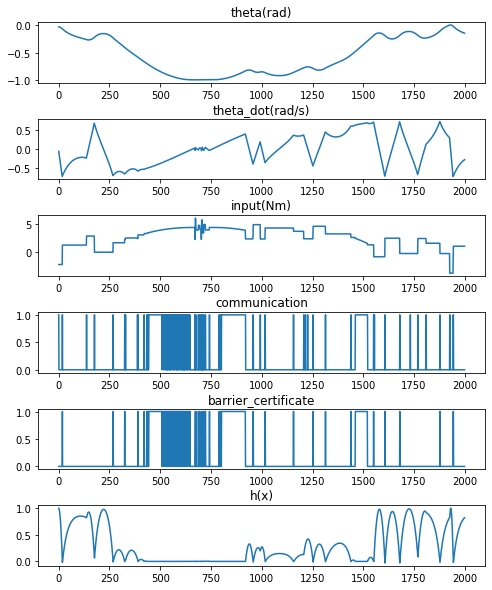

In [9]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication', 'barrier_certificate', 'h(x)'] 
history = a.data_log[0]
x_axis = range(episode_step)
plt.figure(figsize=(8,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(6):
    data = history[:,i]
    plt.subplot(6,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [20]:
a.save_weights('../learned_models_stab/lqr_optimal_agent.h5')

(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

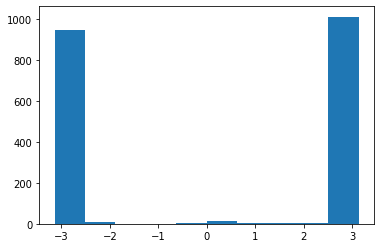

In [11]:
plt.hist(history[:,0])

In [22]:
import csv

with open("../csv/learning_log_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in a.cbf_log:
        writer.writerow(row)

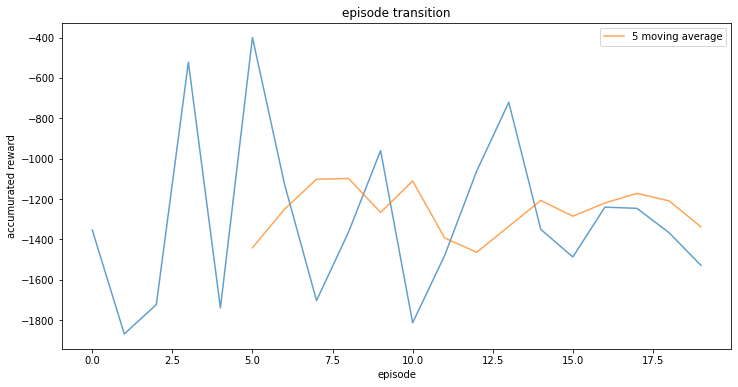

In [34]:
l = 5
plt.figure(figsize=(12,6))
ma = moving_average(a.episode_rewards, l)
plt.plot(range(len(a.episode_rewards)), a.episode_rewards, alpha=0.7)
plt.plot(range(l, len(a.episode_rewards)), ma, label=f'{l} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumurated reward')
plt.title('episode transition')
plt.legend()
plt.show()

In [44]:
rewards = np.array(a.episode_rewards)
import csv

with open("../csv/episode_rewards_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in rewards:
        writer.writerow([row])

In [27]:
for i in range(4):
    theta = np.pi * (2 * i - 3) / 4
    print(f'theta = {theta} : arccos = {np.arccos(np.cos(theta))}, arcsin = {np.arcsin(np.sin(theta))}, arctan = {np.arctan(np.tan(theta))}')

theta = -2.356194490192345 : arccos = 2.356194490192345, arcsin = -0.7853981633974484, arctan = 0.7853981633974484
theta = -0.7853981633974483 : arccos = 0.7853981633974483, arcsin = -0.7853981633974482, arctan = -0.7853981633974483
theta = 0.7853981633974483 : arccos = 0.7853981633974483, arcsin = 0.7853981633974482, arctan = 0.7853981633974483
theta = 2.356194490192345 : arccos = 2.356194490192345, arcsin = 0.7853981633974484, arctan = -0.7853981633974484
